In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM
import copy


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [45]:
roi_names[-1] = 'IPS'
roi_names

['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']

#### Compute binary classification accuracy for different sets of trials
Easy = furthest rows from boundary

Medium = closer rows to boundary, but still in main grid


In [6]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # use correct trials only here
        correct = np.array(l['subject_correct'])
        
        # loop over "axes" - which boundary to compute accuracy for
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            coord_actual = pt_labs[:,ii].round(2)
           
            # easy is the furthest from bound
            # medium is second furthest
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)
            is_hard = dist_from_center<0.8
            is_easy = (dist_from_center==2.4) & is_main_grid
            is_medium = (dist_from_center==0.8) & is_main_grid
           
            # loop over ROIs
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                coords_pred = grid_pts[pred]
                categ_pred = grid_utils.get_categ(coords_pred, ii+1)
                
                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                
                
                inds = is_main_grid & correct
                
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_allmaintrials[si,ri,ti,ii] = d;
                
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_easy & correct
                                                          
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_easytrials[si,ri,ti,ii] = d;
                
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium & correct
                                                      
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_medtrials[si,ri,ti,ii] = d;
                
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_bootstrap_correctonly.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

In [24]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

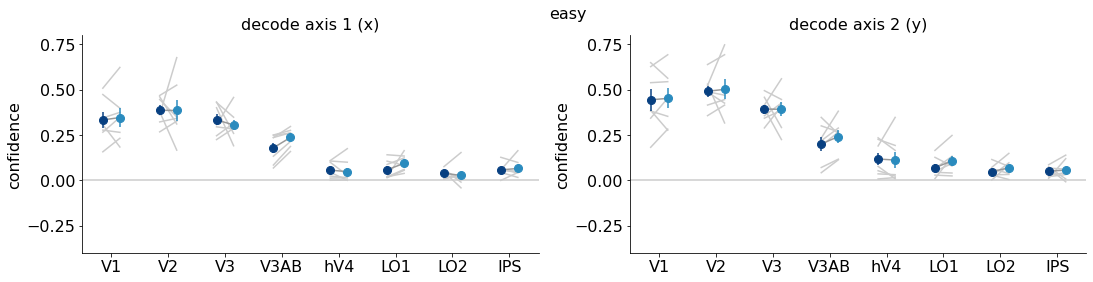

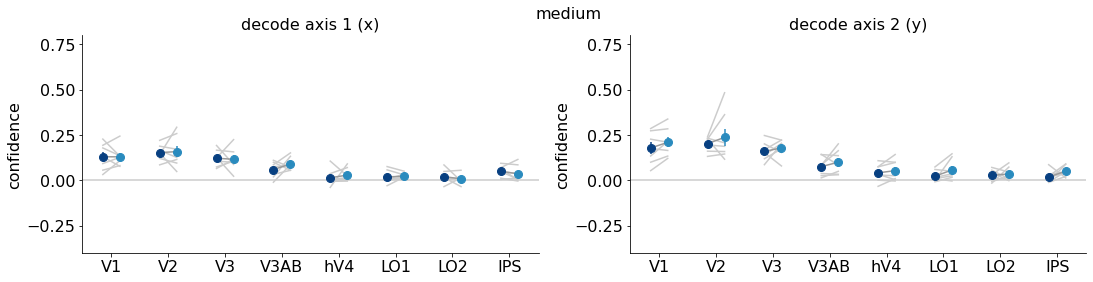

In [48]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15,2)

for rvals, name in zip([conf_easytrials, conf_medtrials], \
                     ['easy','medium']):    
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8, \
                     # markerfacecolor='none', \
                    )
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6],zorder=-5)

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.40, 0.8])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('%s'%name)
    
    figname = os.path.join(figfolder, 'multi_binary_%s.pdf'%(name))
    plt.savefig(figname)


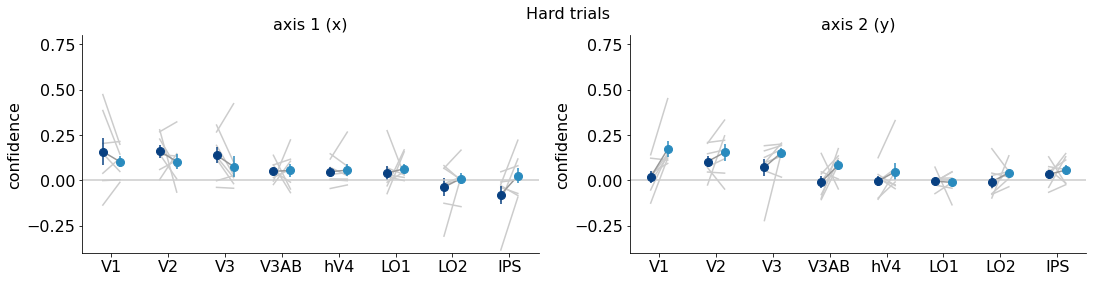

In [49]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,4))


for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    ax = plt.subplot(1,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    # non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, meanvals[:,ti,ii], 'o',color=task_colors[ti], alpha=1, \
                     markersize=8, 
                 # markerfacecolor='none',\
                )
        h = plt.errorbar(x_ticks, meanvals[:,ti,ii], \
                         semvals[:,ti,ii], \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,:,ii],'-',color=[0.6, 0.6, 0.6],zorder=-5)
        
        plt.plot(ri+x_jitter, vals[:,ri,:,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
#         if non_overlapping[ri]:
#             yval = np.max(cihigh[ri,:,ii])+0.02
#             plt.annotate('*',[ri,yval])

    plt.ylim([-0.40, 0.80])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    # plt.legend(lh,task_names[0:2])
    
    plt.title(axis_name)
    
plt.suptitle('Hard trials')

figname = os.path.join(figfolder, 'multi_binary_hard.pdf')
plt.savefig(figname)

In [22]:
for cvals, diffname in zip([conf_easytrials, conf_medtrials], \
                        ['easy','medium']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)
        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        print('\nAnova for confidence w/r/t %s, %s trials'%(axis_name, diffname))
        print(anova_result)



Anova for confidence w/r/t axis 1 (x), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       38.498475     7.0    42.0  0.0000
task       0.216006     1.0     6.0  0.6585
roi:task   0.712520     7.0    42.0  0.6616

Anova for confidence w/r/t axis 2 (y), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       43.600532     7.0    42.0  0.0000
task       1.594126     1.0     6.0  0.2536
roi:task   0.246491     7.0    42.0  0.9706

Anova for confidence w/r/t axis 1 (x), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       18.123794     7.0    42.0  0.0000
task       0.103215     1.0     6.0  0.7589
roi:task   0.459153     7.0    42.0  0.8582

Anova for confidence w/r/t axis 2 (y), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       24.931762     7.0    42.0  0.0000
task      10.216725     1.0     6.0  0.0187
roi:task   0.173503     7.0    42.0  0.9893


In [20]:
ii = 1;
vals = copy.deepcopy(conf_medtrials[:,:,0:2,ii])

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 3546456
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0]
    t2_values = vals[:,rr,1]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

p_values = pvals_nonpar_task
  
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                           'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,-2.158,0.118,5
V2,-0.788,0.504,4
V3,-0.773,0.476,4
V3AB,-1.083,0.346,4
hV4,-0.964,0.416,4
LO1,-1.789,0.091,5
LO2,-0.392,0.718,4
IPSall,-1.525,0.183,6


In [15]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = np.concatenate([copy.deepcopy(conf_easytrials[:,:,0:2,ii:ii+1]), \
                           copy.deepcopy(conf_medtrials[:,:,0:2,ii:ii+1])], axis=3)

    anova_table =  stats_utils.rmanova_3way(vals, ['roi','task','distance'], do_shuffle=False)                            
    
    anova_table['Pr > F'] = anova_table['Pr > F'].round(4)
    
    print('\nClassify %s'%axis_name)
    
    print(anova_table)


Classify axis 1 (x)
                      F Value  Num DF  Den DF  Pr > F
roi                 32.797302     7.0    42.0  0.0000
task                 0.186946     1.0     6.0  0.6806
distance           274.005849     1.0     6.0  0.0000
roi:task             0.557219     7.0    42.0  0.7859
roi:distance        38.814013     7.0    42.0  0.0000
task:distance        0.212810     1.0     6.0  0.6608
roi:task:distance    1.162542     7.0    42.0  0.3445

Classify axis 2 (y)
                      F Value  Num DF  Den DF  Pr > F
roi                 39.127336     7.0    42.0  0.0000
task                 4.198322     1.0     6.0  0.0864
distance           175.307495     1.0     6.0  0.0000
roi:task             0.155973     7.0    42.0  0.9922
roi:distance        38.907741     7.0    42.0  0.0000
task:distance        5.106191     1.0     6.0  0.0646
roi:task:distance    0.607699     7.0    42.0  0.7462


In [23]:
for cvals, diffname in zip([conf_easytrials, conf_medtrials], \
                        ['easy','medium']):

    vals = copy.deepcopy(cvals[:,:,0:2,:])

    anova_table =  stats_utils.rmanova_3way(vals, ['roi','task','class_axis'], do_shuffle=False)                            

    anova_table['Pr > F'] = anova_table['Pr > F'].round(4)

    print('\n%s trials'%diffname)

    print(anova_table)


easy trials
                       F Value  Num DF  Den DF  Pr > F
roi                  43.490356     7.0    42.0  0.0000
task                  0.651793     1.0     6.0  0.4503
class_axis           22.091703     1.0     6.0  0.0033
roi:task              0.444169     7.0    42.0  0.8685
roi:class_axis       12.066132     7.0    42.0  0.0000
task:class_axis       0.646886     1.0     6.0  0.4519
roi:task:class_axis   0.712959     7.0    42.0  0.6613

medium trials
                       F Value  Num DF  Den DF  Pr > F
roi                  24.368585     7.0    42.0  0.0000
task                  3.098721     1.0     6.0  0.1288
class_axis           21.205794     1.0     6.0  0.0037
roi:task              0.211044     7.0    42.0  0.9810
roi:class_axis        6.513769     7.0    42.0  0.0000
task:class_axis      12.163327     1.0     6.0  0.0130
roi:task:class_axis   0.544780     7.0    42.0  0.7955


#### Repeated measures ANOVA
Medium trials

3 way, [ROI x task x classifier axis]

In [8]:
# Just compare the two "linear" tasks here

vals = copy.deepcopy(conf_medtrials[:,:,0:2,:])

class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2*2), \
                           'roi': np.tile(np.repeat(np.arange(n_rois), 2*2),[n_subjects,]), \
                           'task': np.tile(np.repeat(np.arange(2), 2), [n_subjects*n_rois,]), \
                           'class_axis': np.tile(np.arange(2), [n_subjects*n_rois*2,])})

class_values = np.zeros((n_subjects*n_rois*2*2))
for si in range(n_subjects):
    for ri in range(n_rois):
        for ti in range(2):
            inds = (class_df['subject']==si) & (class_df['roi']==ri) & (class_df['task']==ti)
            # print(np.sum(inds))
            class_values[inds] = vals[si,ri,ti,:]
class_df['class_values'] = class_values

model = AnovaRM(data=class_df, \
                depvar='class_values', \
                subject='subject', \
                within = ['roi','task','class_axis'],
               )
rm_result = model.fit()
print(rm_result)

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
roi                 24.3686 7.0000 42.0000 0.0000
task                 3.0987 1.0000  6.0000 0.1288
class_axis          21.2058 1.0000  6.0000 0.0037
roi:task             0.2110 7.0000 42.0000 0.9810
roi:class_axis       6.5138 7.0000 42.0000 0.0000
task:class_axis     12.1633 1.0000  6.0000 0.0130
roi:task:class_axis  0.5448 7.0000 42.0000 0.7955



#### Two-way RM Anova, for each type of decoding
[ROI x task]

In [9]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

    vals = copy.deepcopy(conf_medtrials[:,:,0:2,ii])

    class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2), \
                               'roi': np.tile(np.repeat(np.arange(n_rois), 2),[n_subjects,]), \
                               'task': np.tile(np.arange(2), [n_subjects*n_rois,])})

    class_values = np.zeros((n_subjects*n_rois*2))
    for si in range(n_subjects):
        for ri in range(n_rois):
            inds = (class_df['subject']==si) & (class_df['roi']==ri)
            class_values[inds] = vals[si,ri,:]
    class_df['class_values'] = class_values

    model = AnovaRM(data=class_df, \
                    depvar='class_values', \
                    subject='subject', \
                    within = ['roi','task'],
                   )
    rm_result = model.fit()
    print('Classify %s'%axis_name)
    print(rm_result)

Classify axis 1 (x)
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi      18.1238 7.0000 42.0000 0.0000
task      0.1032 1.0000  6.0000 0.7589
roi:task  0.4592 7.0000 42.0000 0.8582

Classify axis 2 (y)
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
roi      24.9318 7.0000 42.0000 0.0000
task     10.2167 1.0000  6.0000 0.0187
roi:task  0.1735 7.0000 42.0000 0.9893



Medium trials - do individual ROIs show a task difference?

In [11]:
ii = 0
vals = copy.deepcopy(conf_medtrials[:,:,0:2,:])

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 1223534
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0,ii]
    t2_values = vals[:,rr,1,ii]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_task
p_values = pvals_nonpar_task
# orig_shape = p_values.shape
# mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
#                                                                 alpha=0.01)
# mask_fdr = np.reshape(mask_fdr, orig_shape)
# pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                           # 'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, \
                           'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
# mask_fdr_vert = mask_fdr
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,0.023,0.993,4
V2,-0.178,0.866,4
V3,0.209,0.832,4
V3AB,-1.329,0.232,5
hV4,-0.622,0.515,6
LO1,-0.347,0.751,4
LO2,0.716,0.500,4
IPSall,0.986,0.326,5


In [12]:
ii = 1
vals = copy.deepcopy(conf_medtrials[:,:,0:2,:])

tstats_task = np.zeros((n_rois,),dtype=float)
pvals_task = np.zeros((n_rois,),dtype=float)
pvals_nonpar_task = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 1223534
for rr in range(n_rois):
    
    t1_values = vals[:,rr,0,ii]
    t2_values = vals[:,rr,1,ii]
    
    stats = scipy.stats.ttest_rel(t1_values, t2_values)
    
    tstats_task[rr] = stats.statistic
    pvals_task[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_task[rr] = p
    
    subj_diffs = t1_values - t2_values
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_task
p_values = pvals_nonpar_task
# orig_shape = p_values.shape
# mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
#                                                                 alpha=0.01)
# mask_fdr = np.reshape(mask_fdr, orig_shape)
# pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                        'pvalue': p_values, \
                           # 'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, \
                           'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
# mask_fdr_vert = mask_fdr
task_df.round(3)

,t-stat for task 1 > task 2,pvalue,n_subs_indiv
V1,-2.158,0.110,5
V2,-0.788,0.508,4
V3,-0.773,0.483,4
V3AB,-1.083,0.344,4
hV4,-0.964,0.428,4
LO1,-1.789,0.097,5
LO2,-0.392,0.719,4
IPSall,-1.525,0.177,6


In [31]:
p_values

array([0.94854217, 0.80221446, 0.92965308, 0.3582644 , 0.46256999,
       0.7549118 , 0.7595552 , 0.61504151])

In [14]:
t1_values, t2_values

(array([ 0.03208011, -0.00161752, -0.00077091,  0.07129727,  0.02218772,
         0.01525054, -0.01344662]),
 array([0.02560733, 0.03387819, 0.02330099, 0.00207411, 0.09021318,
        0.01477302, 0.06541919]))

Easy trials

In [55]:
vals = copy.deepcopy(conf_easytrials[:,:,0:2,:])

class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2*2), \
                           'roi': np.tile(np.repeat(np.arange(n_rois), 2*2),[n_subjects,]), \
                           'task': np.tile(np.repeat(np.arange(2), 2), [n_subjects*n_rois,]), \
                           'class_axis': np.tile(np.arange(2), [n_subjects*n_rois*2,])})

class_values = np.zeros((n_subjects*n_rois*2*2))
for si in range(n_subjects):
    for ri in range(n_rois):
        for ti in range(2):
            inds = (class_df['subject']==si) & (class_df['roi']==ri) & (class_df['task']==ti)
            # print(np.sum(inds))
            class_values[inds] = vals[si,ri,ti,:]
class_df['class_values'] = class_values

model = AnovaRM(data=class_df, \
                depvar='class_values', \
                subject='subject', \
                within = ['roi','task','class_axis'],
               )
rm_result = model.fit()
print(rm_result)

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
roi                 42.4615 7.0000 42.0000 0.0000
task                 0.6558 1.0000  6.0000 0.4490
class_axis          19.6155 1.0000  6.0000 0.0044
roi:task             0.4675 7.0000 42.0000 0.8524
roi:class_axis      11.6508 7.0000 42.0000 0.0000
task:class_axis      0.4278 1.0000  6.0000 0.5373
roi:task:class_axis  0.5120 7.0000 42.0000 0.8203



All main grid trials

In [58]:
vals = copy.deepcopy(conf_allmaintrials[:,:,0:2,:])

class_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2*2), \
                           'roi': np.tile(np.repeat(np.arange(n_rois), 2*2),[n_subjects,]), \
                           'task': np.tile(np.repeat(np.arange(2), 2), [n_subjects*n_rois,]), \
                           'class_axis': np.tile(np.arange(2), [n_subjects*n_rois*2,])})

class_values = np.zeros((n_subjects*n_rois*2*2))
for si in range(n_subjects):
    for ri in range(n_rois):
        for ti in range(2):
            inds = (class_df['subject']==si) & (class_df['roi']==ri) & (class_df['task']==ti)
            # print(np.sum(inds))
            class_values[inds] = vals[si,ri,ti,:]
class_df['class_values'] = class_values

model = AnovaRM(data=class_df, \
                depvar='class_values', \
                subject='subject', \
                within = ['roi','task','class_axis'],
               )
rm_result = model.fit()
print(rm_result)

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
roi                 37.8564 7.0000 42.0000 0.0000
task                 1.1878 1.0000  6.0000 0.3176
class_axis          20.2092 1.0000  6.0000 0.0041
roi:task             0.2982 7.0000 42.0000 0.9507
roi:class_axis      15.2240 7.0000 42.0000 0.0000
task:class_axis      4.3090 1.0000  6.0000 0.0832
roi:task:class_axis  0.4221 7.0000 42.0000 0.8830



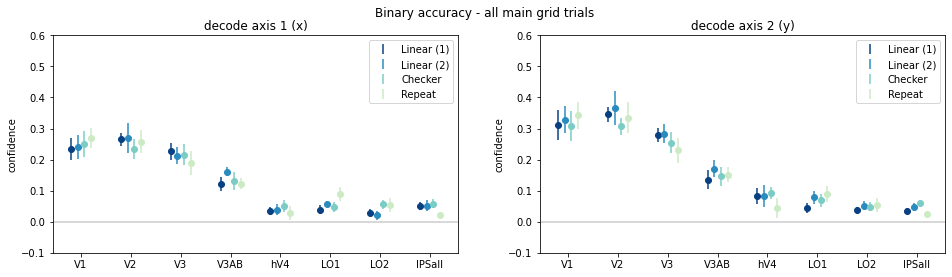

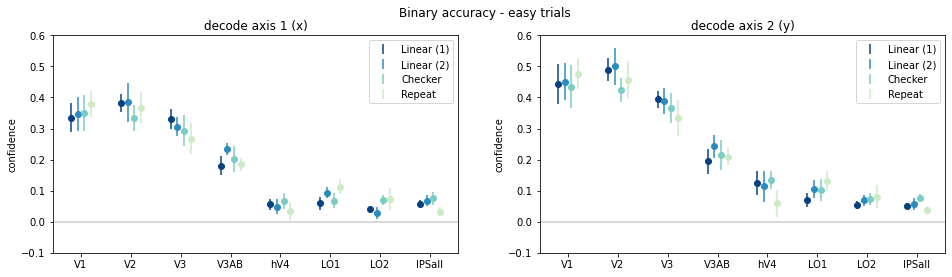

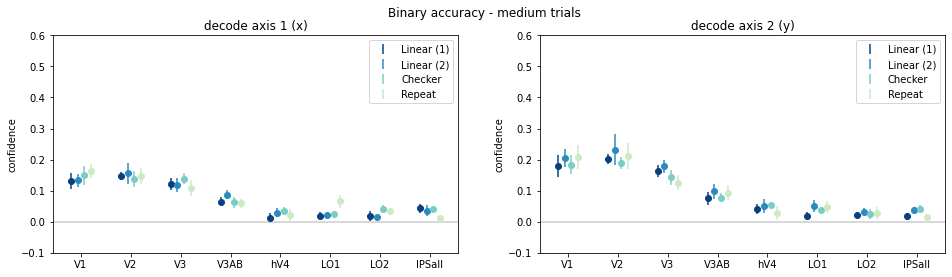

In [13]:
ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 4)

for cvals, name in zip([conf_allmaintrials, conf_easytrials, conf_medtrials], \
                     ['all main grid trials', 'easy trials','medium trials']):
    
    plt.figure(figsize=(16,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = cvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
          
        plt.ylim([-0.1, 0.6])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('Binary accuracy - %s'%name)
